In [1]:
import numpy as np
from point_history import getmes
import pickle
import datetime
from get_point_map import get
from get_point_history import pget
from netCDF4 import Dataset
import pandas as pd
from ipywidgets import interact
import matplotlib.pyplot as plt

In [2]:
import folium

In [3]:
import itertools

In [4]:
from pandas.compat import u

In [5]:
%matplotlib notebook

In [6]:
SAVEPATH='tmp/'

In [463]:
path='/mnt/web/brey/hincast/'

In [464]:
SAVEPATH='tmp/'#/mnt/pandora/Users_Critech/Thomas/HYFLUX/'

In [465]:
basename='med'

In [466]:
t1='20131101.00'

In [496]:
t2='20131201.00'

In [497]:
sdate=datetime.datetime.strptime(t1,'%Y%m%d.%H')

In [498]:
edate=datetime.datetime.strptime(t2,'%Y%m%d.%H')

In [499]:
path0=path+'{}/'.format(t1)

In [500]:
with open(path0+basename+'.pkl', 'r') as f:
    ptr=pickle.load(f)

In [501]:
iloc=1841 # CHANGE THIS FOR ANALYSIS OF ANOTHER OBS POINT

In [502]:
t,s,plat,plon,bname,bid = getmes(sdate,edate,iloc) # measured data
dic0={'t_gauge':t, 'sh':[a for [a,b,c] in s], 'tide':[b for [a,b,c] in s], 'ss':[c for [a,b,c] in s]}
data0=pd.DataFrame(dic0)
data0=data0.set_index('t_gauge')


In [503]:
tcw,cw,mlat,mlon,jc,ic=get(t1,t2,path,basename,plat,plon) # map interpolated data
dic1={'t_map':tcw, 's_map':cw}
data1=pd.DataFrame.from_dict(dic1)
data1=data1.set_index('t_map')
data=data0.join(data1, how='outer')

In [504]:
hcw,hw,hlat,hlon=pget(t1,t2,path,basename,ptr[iloc]) # obs point 1 min sampling 
dic2={'t_his':hcw, 's_his':hw}
data2=pd.DataFrame.from_dict(dic2)
data2=data2.set_index('t_his')
data=data.join(data2, how='outer')

In [505]:
#check that the 'returned' iDs are the same as the read ones
np.int(bid) == iloc

True

In [506]:
data.head()

,sh,ss,tide,s_map,s_his
2013-11-01 00:00:00,NaN,NaN,NaN,0.0,0.000000
2013-11-01 00:01:00,NaN,NaN,NaN,NaN,0.000051
2013-11-01 00:02:00,NaN,NaN,NaN,NaN,0.000203
2013-11-01 00:03:00,NaN,NaN,NaN,NaN,0.000448
2013-11-01 00:04:00,NaN,NaN,NaN,NaN,0.000773


In [507]:
if data['sh'].dropna().sum() is 0:
    print 'no obs, replacing with zeros'
    data[['sh','ss','tide']]=0.0

In [508]:
data.head()

,sh,ss,tide,s_map,s_his
2013-11-01 00:00:00,NaN,NaN,NaN,0.0,0.000000
2013-11-01 00:01:00,NaN,NaN,NaN,NaN,0.000051
2013-11-01 00:02:00,NaN,NaN,NaN,NaN,0.000203
2013-11-01 00:03:00,NaN,NaN,NaN,NaN,0.000448
2013-11-01 00:04:00,NaN,NaN,NaN,NaN,0.000773


### read grid 

In [509]:
d=Dataset(path0+'trim-'+basename+'.nc')

In [510]:
xg=d['XCOR'][:]
yg=d['YCOR'][:]

In [511]:
xz=d['XZ'][:]
yz=d['YZ'][:]

In [512]:
mapa = folium.Map(location=[plat, plon], zoom_start=12)

In [513]:
folium.Marker([plat,plon], popup=bname).add_to(mapa)

In [514]:
plat,plon, ic, jc

('39.148', '8.309', 207, 160)

In [515]:
folium.CircleMarker([yz[ic,jc],xz[ic,jc]], popup='{},{}/{},{}'.format(mlat,mlon,jc,ic)).add_to(mapa)

In [516]:
folium.CircleMarker([mlat,mlon], popup='{},{}'.format(mlat,mlon),fill_color='blue').add_to(mapa)

In [517]:
mlat,mlon

(39.169749400000001, 8.2840057250000001)

In [518]:
folium.CircleMarker([hlat,hlon], popup='{},{}'.format(hlat,hlon),fill_color='green').add_to(mapa)

In [519]:
%%skip
folium.LatLngPopup().add_to(mapa) # click to show lat lon

In [520]:
a=np.arange(-5,5)
b=np.arange(-5,5)
glist=[]
for r in itertools.product(a,b): glist.append((r[0],r[1]))
#glist

In [521]:
for k,l in glist:
    try:
        m1=ic+k
        m2=jc+l
        xgrid=zip(yg[m1,m2-5:m2+5],xg[m1,m2-5:m2+5])
        ygrid=zip(yg[m1-5:m1+5,m2],xg[m1-5:m1+5,m2])
        folium.PolyLine(xgrid,weight=1, color='black').add_to(mapa)
        folium.PolyLine(ygrid,weight=1, color='black').add_to(mapa)
        folium.CircleMarker([yg[m1,m2],xg[m1,m2]], popup='{},{}'.format(m1,m2), radius=50).add_to(mapa)
        folium.CircleMarker([yz[m1,m2],xz[m1,m2]], popup='{},{}'.format(m1,m2), radius=50, fill_color='red').add_to(mapa)
    except Exception as e:
        print e
        pass

In [522]:
mapa

<IPython.core.display.Javascript object>


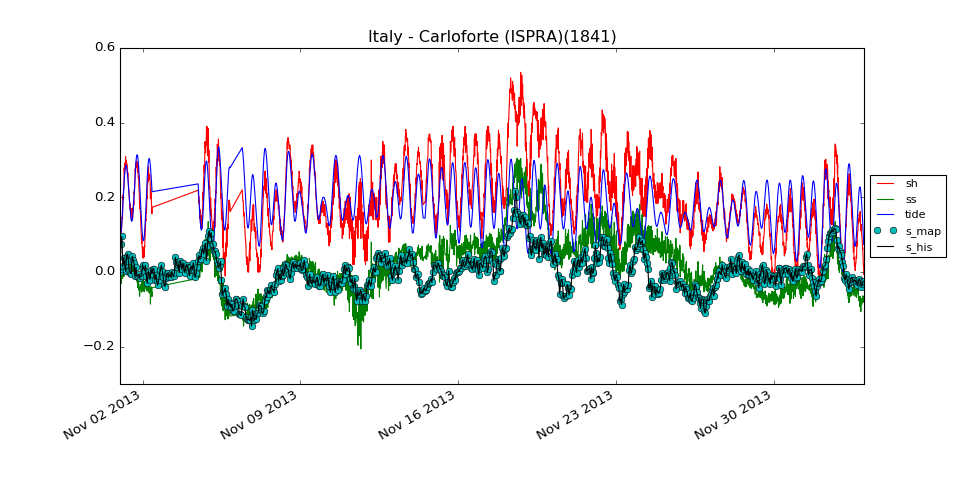

In [523]:
ax=data[['sh','ss','tide']].dropna().apply(pd.to_numeric).plot(figsize=(12,6),style=['r-','g-','b-'])
data[['s_map','s_his']].dropna().apply(pd.to_numeric).plot(ax=ax, style=['co','k-'])
ax.legend(loc='center left', bbox_to_anchor=(1.,.5), prop={'size':10})
ax.set_title(bname+'('+bid+')')

## check variance

In [ ]:
obs = data['ss'].dropna().apply(pd.to_numeric)

In [ ]:
num = data['s_map'].dropna().apply(pd.to_numeric)

computer rolling mean every 60 points

In [ ]:
ma = obs.rolling(60).mean()

In [ ]:
mstd = obs.rolling(60).std() #standard deviation

In [ ]:
#plot them
plt.figure(figsize=(12,6))
plt.plot(obs.index, obs, 'k')
plt.plot(ma.index, ma, 'b')
plt.plot(num.index, num, 'r')
plt.fill_between(mstd.index, ma-2*mstd, ma+2*mstd, color='b', alpha=0.2)
plt.legend(loc=0)

## Get All forecasting data

In [ ]:
dt=(edate-sdate).total_seconds()
ndt=dt/(3600*12)
ndt=np.int(ndt)+1

In [ ]:
combined=[] # store time and height
tstamp = [] # for use later

In [ ]:
tot=[]

In [ ]:
indx=pd.date_range(sdate, edate, freq='12H')

In [ ]:
val=[]

In [ ]:
for it in range(ndt):
    idate=sdate+datetime.timedelta(hours=12*it)
    dstamp=datetime.datetime.strftime(idate,'%Y%m%d.%H')
    path0=path+'{}/{}/{}/{:02d}/'.format(idate.year,idate.month,idate.day,idate.hour)
    filename=path0+'trih-'+basename+'.nc'
    d =  Dataset(filename)
    ha=d.variables['ZWL'][:,ptr[iloc]] # all values
    t=d.variables['time'][:]
    tw=[]
    for it in t:
        tw.append(idate+datetime.timedelta(seconds=np.int(it)))
    ttw=[(item-t[0])/60. for item in t]
    dic={'time':tw, 'numerical storm surge':ha, 'forecast_time':ttw}
    val.append(ha)
    data=pd.DataFrame.from_dict(dic)
    data=data.set_index('time')
    tot.append(data)

In [ ]:
tota=pd.concat(tot,keys=indx)

In [ ]:
tota.head()

In [ ]:
dat=tota.drop('forecast_time',1)

In [ ]:
dat.head()

## plot all forecasts

In [ ]:
dat.unstack(level=0).plot(figsize=(12,6),legend=False)

In [ ]:
## save the data
dat.to_csv(SAVEPATH+bname+'time_ref.csv', header=None)

## Analysis 

In [ ]:
mindx=dat.xs('2013-10-21 00:00:00')

### average of 5 minutes 

In [ ]:
mindx.rolling(5,center=True).mean()[::60][:10] # rolling mean ever 5 values, given every 60 indeces 

In [ ]:
#Test the above
ar=[]
for i in range(0,mindx.shape[0],60):
    ar.append(np.mean(mindx[i-2:i+3]))
ar[:10]    

### maximum of hourly data

In [ ]:
mindx.rolling(60,center=True).max()[::60][:10]


In [ ]:
# test
ar=[]
for i in range(0,mindx.shape[0],60):
    ar.append(np.max(mindx[i-30:i+31]))
ar[:10]    

## compute corellation between measured and computed

In [ ]:
num.head()

In [ ]:
obs.head()

In [ ]:
rnum=num.reindex(obs.index,method='pad')

In [ ]:
rnum.corr(obs) #total correlation

In [ ]:
rnum.rolling(window=10, center=True).corr(obs).mean()

In [ ]:
rnum.rolling(window=10, center=True).corr(obs).plot()

## replace index

In [ ]:
tota.head()

In [ ]:
tota.drop('forecast_time',1, inplace=True)

In [ ]:
tota.head()

In [ ]:
tota.index.tolist()[:10]

In [ ]:
ht=np.array([np.arange(4321) for i in range(tota.index.levels[0].shape[0])]).ravel()

In [ ]:
ht.shape

In [ ]:
len(tota.index.tolist())

In [ ]:
index0=[(a, c) for (a,b),c in zip(tota.index.tolist(),ht)]

In [ ]:
tota.index=pd.MultiIndex.from_tuples(index0,names=tota.index.names)

In [ ]:
tota.head()

In [ ]:
tota.unstack(level=0).head()

### rolling average for all

In [ ]:
s=tota.unstack(level=0)

In [ ]:
s.head()

In [ ]:
s.rolling(60,center=True).max()[::60] # max within 1 hour centered on the hour

### test the above values

In [ ]:
testd=s.iloc[:,s.columns.get_level_values(1)=='2013-10-23 00:00:00']

In [ ]:
testd.rolling(60,center=True).max()[::60][:10]

In [ ]:
testd[90:150].max()

In [ ]:
ar=[]
for i in range(0,testd.shape[0],60):
    ar.append(np.max(testd[i-30:i+30]))
ar[:10]   

In [ ]:
## save the data
s.to_csv(SAVEPATH+bname+'forecast.csv')